In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pickle
from data_loader.data_loader import TrainDataProvider
from model.models import Encoder, Generator, Discriminator, Decoder
from utils.util import *

/opt/homebrew/Caskroom/miniconda/base/envs/openmmlab/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
En = Encoder()
De = Decoder()
D = Discriminator(category_num=25)

from_model_path = './checkpoint/'
encoder_path = '60-Encoder.pkl'
decoder_path = '60-Decoder.pkl'
discriminator_path = '60-Discriminator.pkl'
data_dir = './data/'
fixed_dir = './fixed_sample'


FONTS_NUM = 25
BATCH_SIZE = 128
IMG_SIZE = 128
EMBEDDING_DIM = 128

En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path), map_location='cpu'))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path), map_location='cpu'))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path), map_location='cpu'))

data_provider = TrainDataProvider(data_dir)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

embeddings = torch.load(os.path.join(data_dir, 'EMBEDDINGS.pkl'), map_location='cpu')

font_labels = list(range(25))
fake_targets = {i: [] for i in font_labels}
real_targets = {i: [] for i in font_labels}

val_batch_iter = data_provider.get_val_iter(BATCH_SIZE, with_charid=True)

for i, batch in enumerate(val_batch_iter):
    labels, char_id, batch_images = batch
    batch_images = batch_images.cpu()
    embedding_ids = labels
    
    # target / source images
    real_target = batch_images[:, 0, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    real_source = batch_images[:, 1, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    
    # generate fake image
    fake_target, encoded_source, _ = Generator(real_source, En, De, embeddings, embedding_ids, GPU=False)
    
    # save fake images by filtering with fonts
    for label, (real_target, fake) in zip(labels, zip(real_target, fake_target)):
        fake_targets[label].append(fake.cpu().detach().numpy())
        real_targets[label].append(real_target.cpu().detach().numpy())
    
    if i == 20:
        break

count = 0
for key, value in fake_targets.items():
    count += len(fake_targets[key])
    print('[font: %d]' % key, len(fake_targets[key]))
print('all images count: ', count)

unpickled total 46963 examples
unpickled total 11787 examples
train examples -> 46963, val examples -> 11787
total batches: 367
[font: 0] 111
[font: 1] 99
[font: 2] 102
[font: 3] 109
[font: 4] 113
[font: 5] 112
[font: 6] 106
[font: 7] 103
[font: 8] 107
[font: 9] 115
[font: 10] 111
[font: 11] 103
[font: 12] 123
[font: 13] 120
[font: 14] 105
[font: 15] 107
[font: 16] 79
[font: 17] 103
[font: 18] 116
[font: 19] 110
[font: 20] 102
[font: 21] 97
[font: 22] 124
[font: 23] 108
[font: 24] 103
all images count:  2688


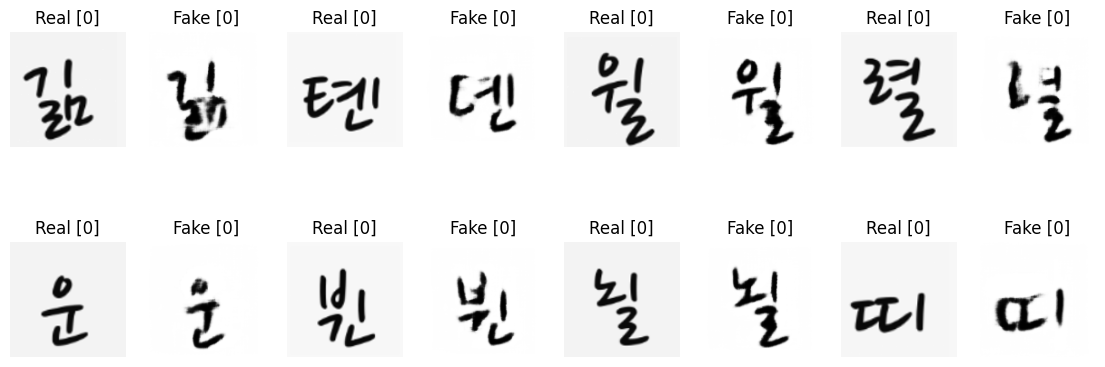

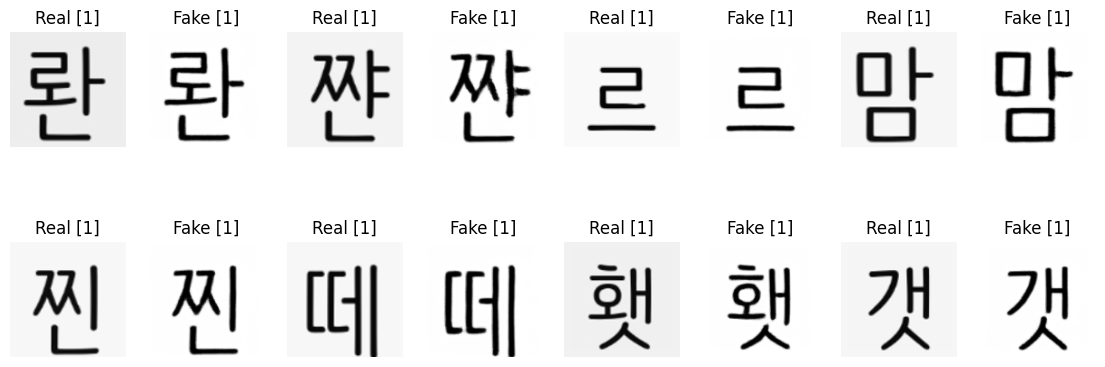

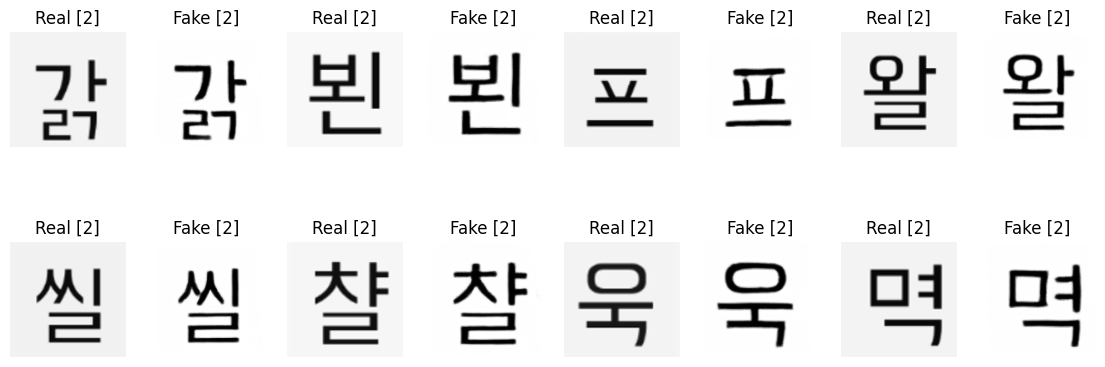

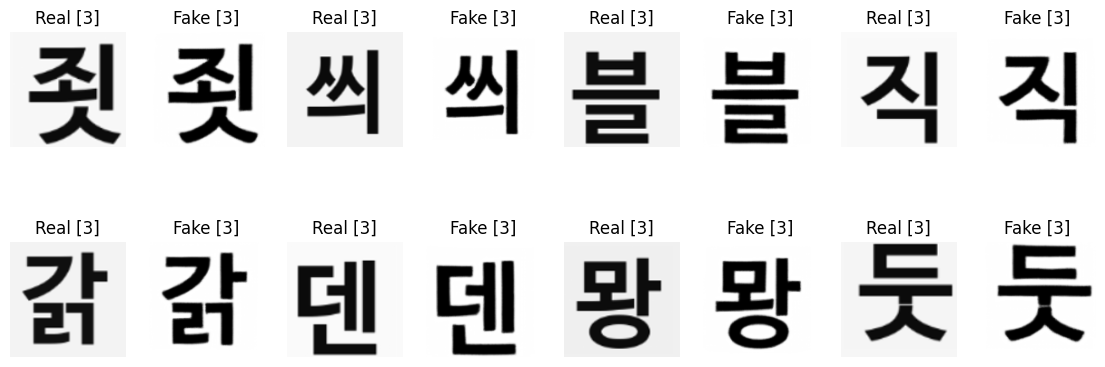

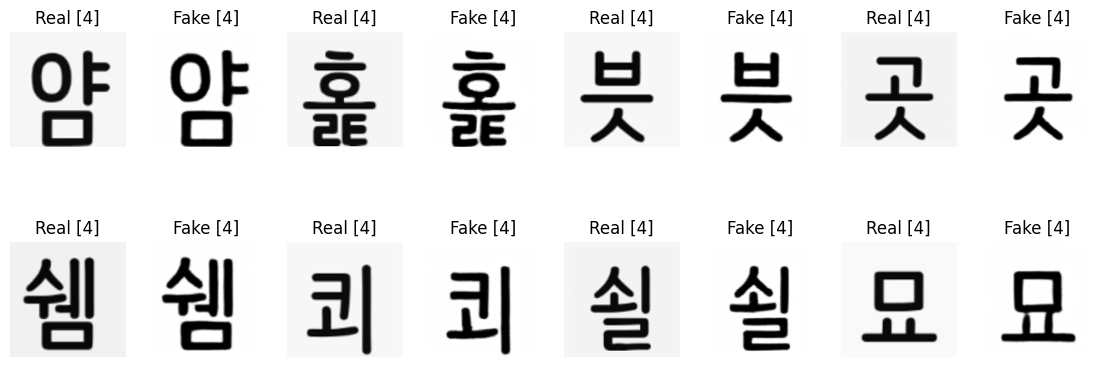

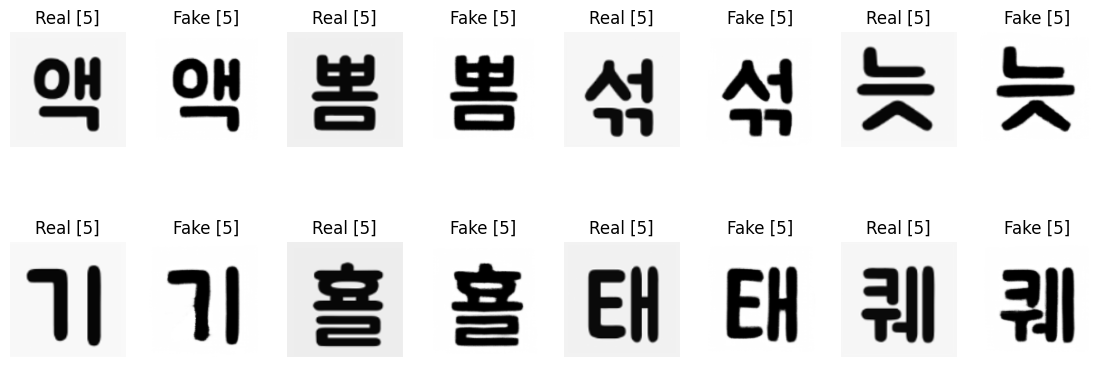

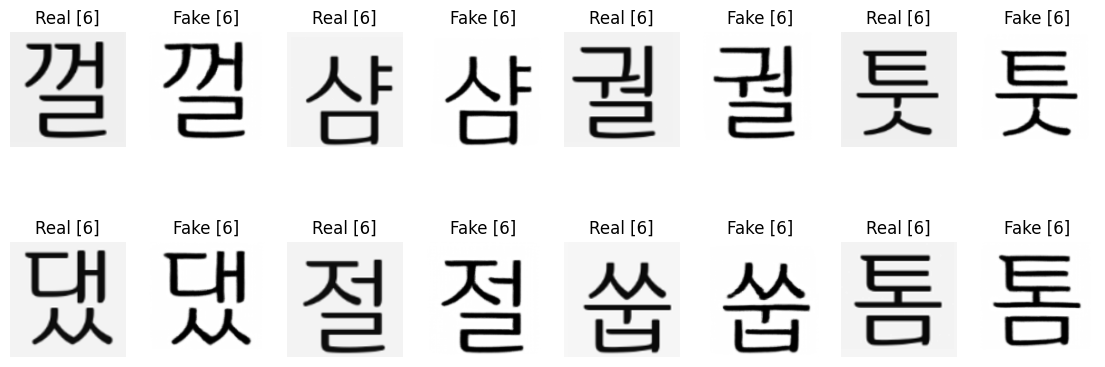

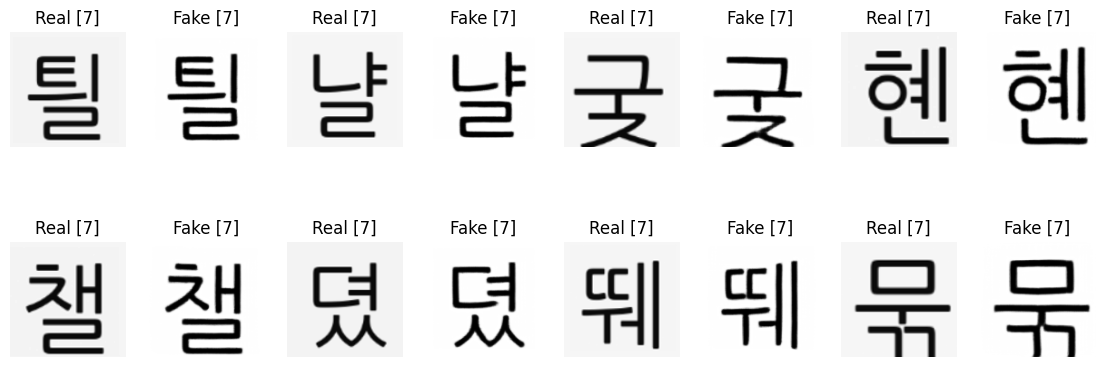

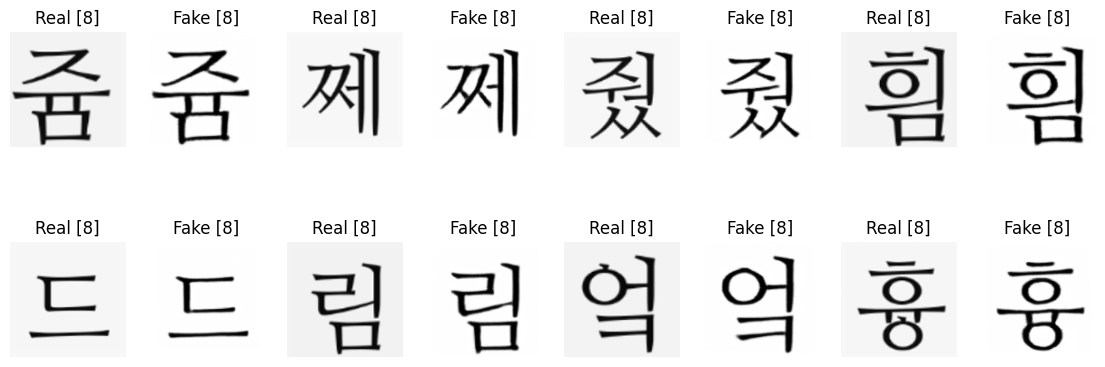

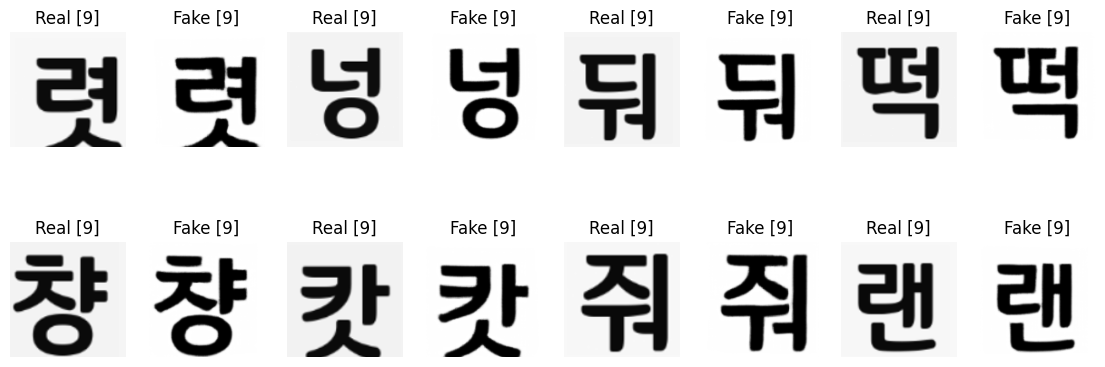

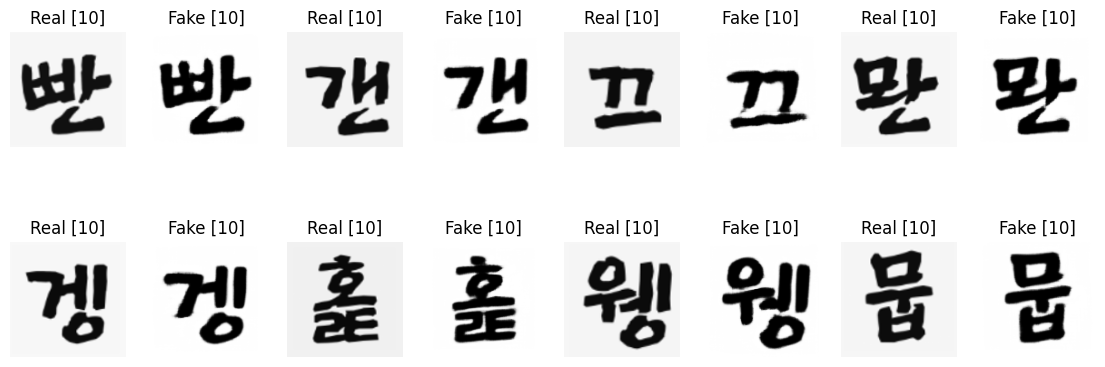

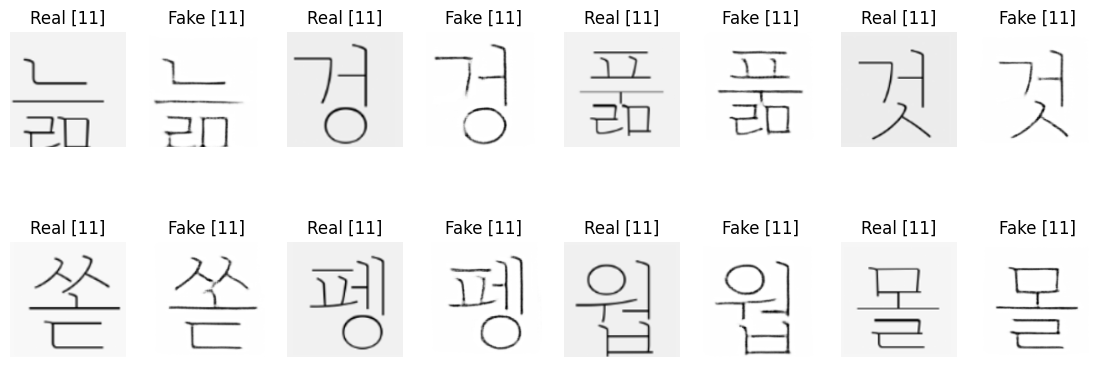

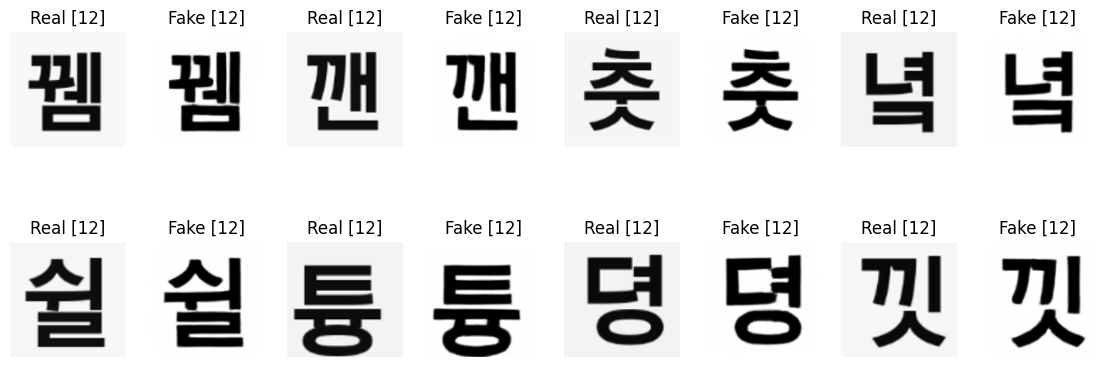

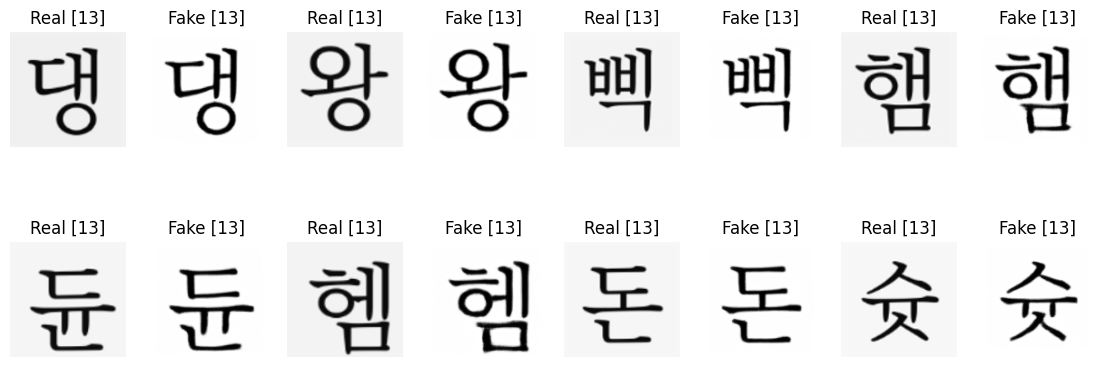

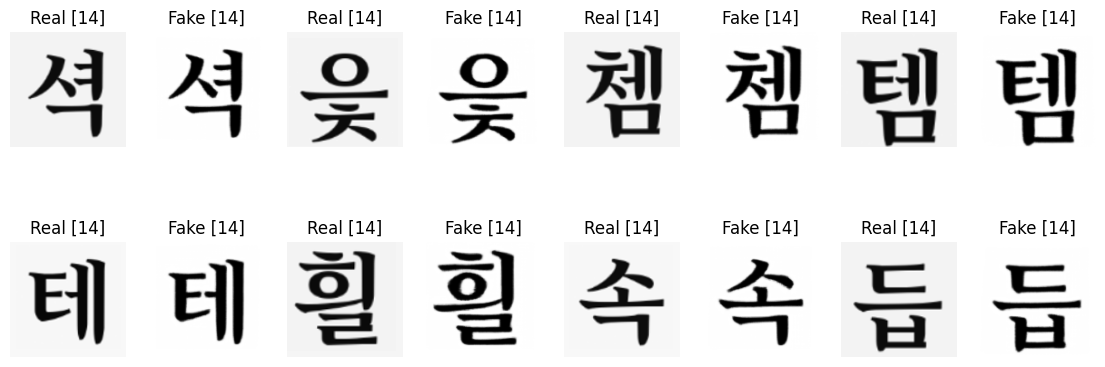

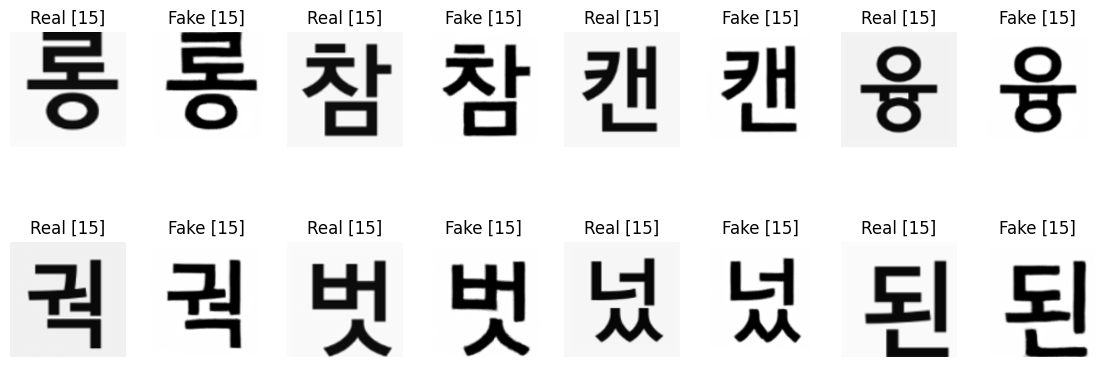

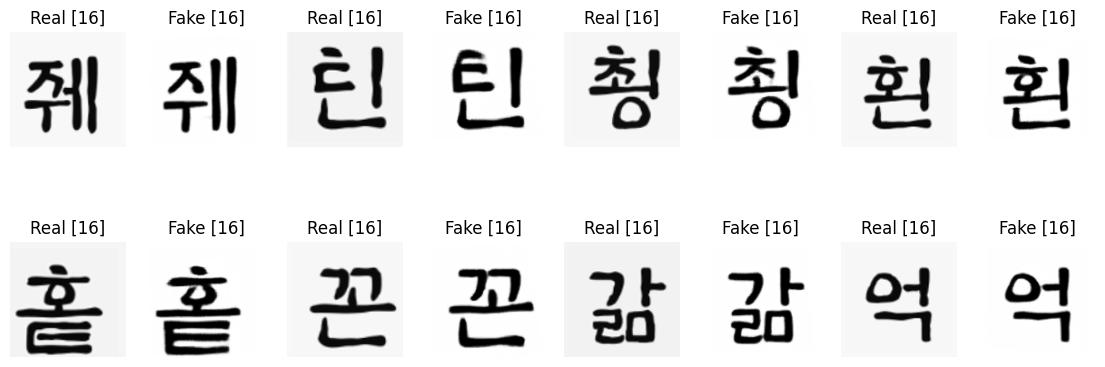

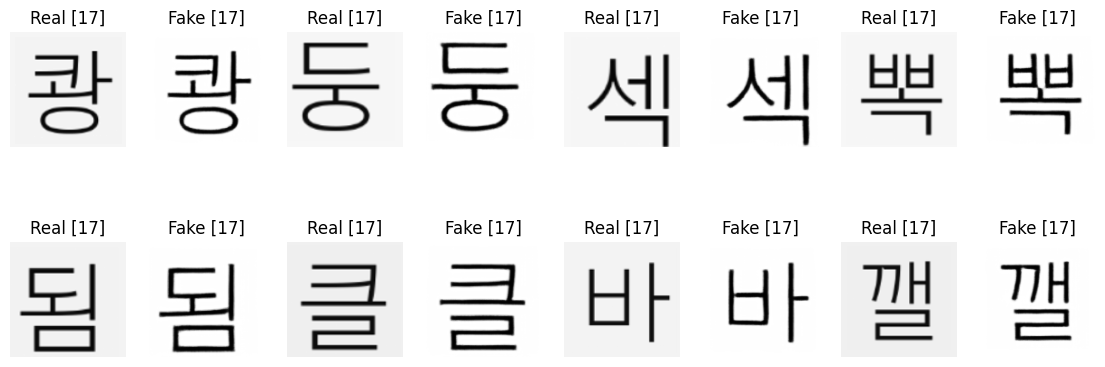

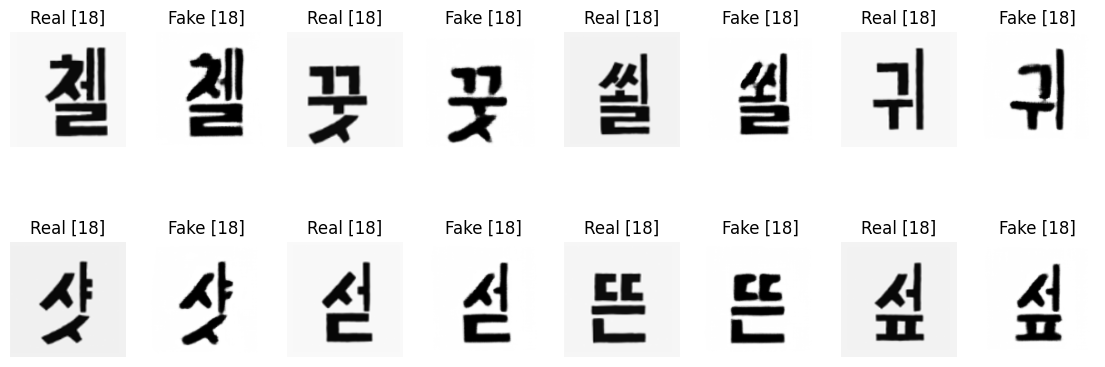

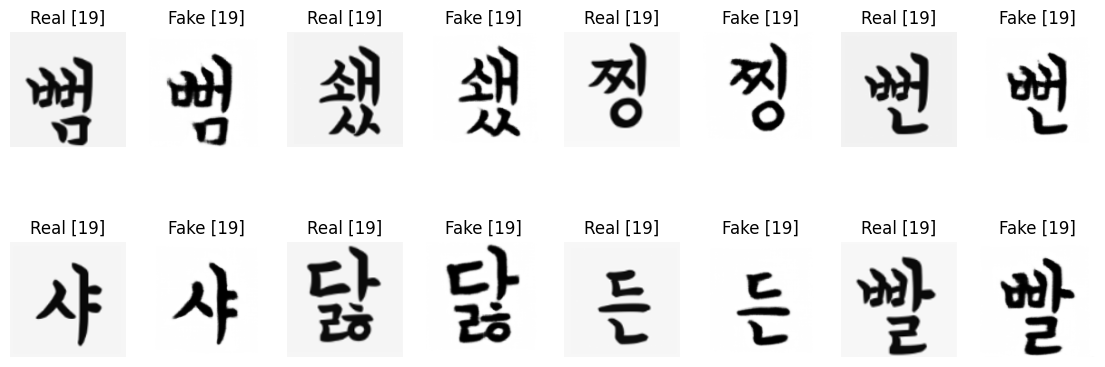

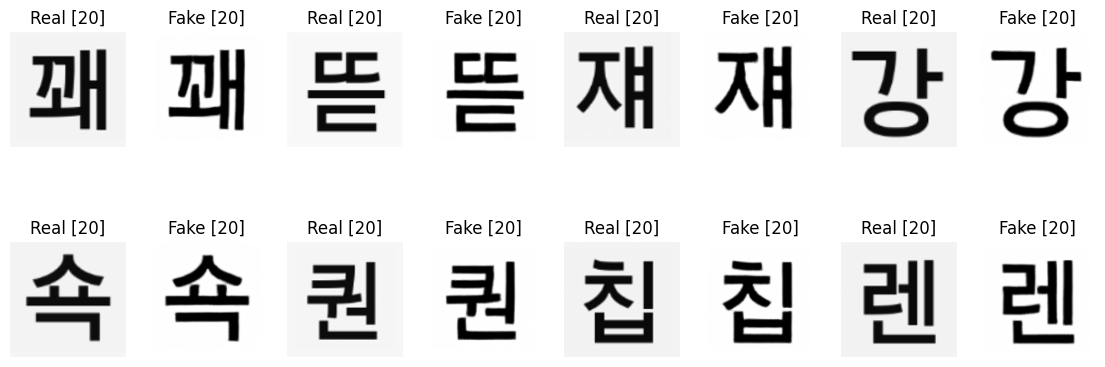

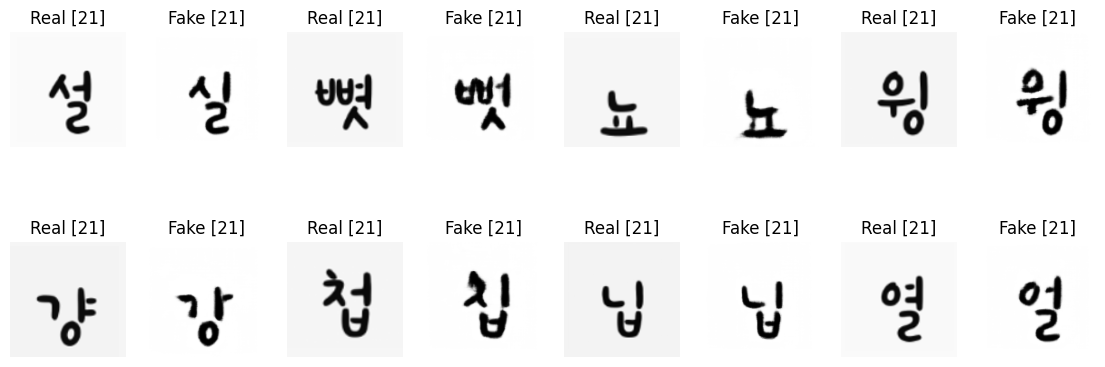

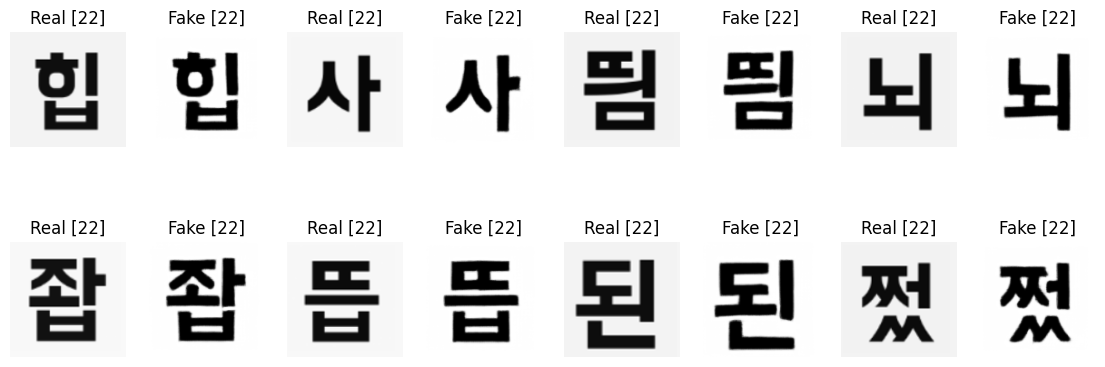

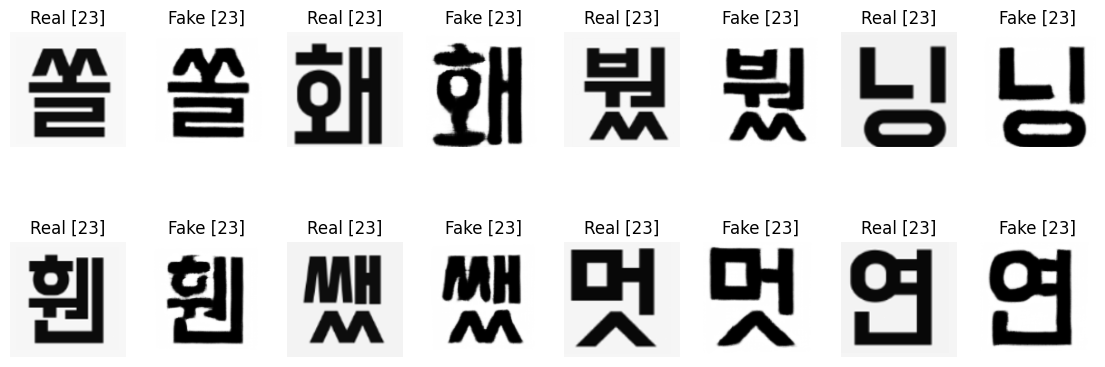

In [14]:
for i in range(24):
    show_comparison(i, real_targets, fake_targets, show_num=8)